# EDA Visualizations for Image Recognition (Conv Filter Edition)

## Dependencies and Imports

In [2]:
!pip install -q timm

In [1]:
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import timm
import torch
import torchvision
from torchvision.models.feature_extraction import (create_feature_extractor,
                                                   get_graph_node_names)

%matplotlib inline
import glob
import os
from math import ceil
import random

import cv2
import PIL
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

from typing import *

# importing modules
import urllib.request
from PIL import Image

## Config and Logging

In [2]:
import logging
from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

def init_logger(log_file: str = "info.log") -> logging.Logger:
    """Initialize logger and save to file.

    Consider having more log_file paths to save, eg: debug.log, error.log, etc.

    Args:
        log_file (str, optional): [description]. Defaults to Path(LOGS_DIR, "info.log").

    Returns:
        logging.Logger: [description]
    """
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    stream_handler = StreamHandler()
    stream_handler.setFormatter(
        Formatter("%(asctime)s: %(message)s", "%Y-%m-%d %H:%M:%S")
    )
    file_handler = FileHandler(filename=log_file)
    file_handler.setFormatter(
        Formatter("%(asctime)s: %(message)s", "%Y-%m-%d %H:%M:%S")
    )
    logger.addHandler(stream_handler)
    logger.addHandler(file_handler)

    return logger

logger = init_logger()

### Utils

In [3]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title=""):
    fig, myaxes = plt.subplots(
        figsize=(20, 15),
        nrows=ceil(len(img_matrix_list) / ncols),
        ncols=ncols,
        squeeze=False,
    )
    fig.suptitle(main_title, fontsize=30)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
    plt.show()

## Seeding

In [4]:
def seed_all(seed: int = 1992) -> None:
    """Seed all random number generators."""
    print(f"Using Seed Number {seed}")

    os.environ["PYTHONHASHSEED"] = str(seed)  # set PYTHONHASHSEED env var at fixed value
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)  # pytorch (both CPU and CUDA)
    np.random.seed(seed)  # for numpy pseudo-random generator
    # set fixed value for python built-in pseudo-random generator
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True


def seed_worker(_worker_id) -> None:
    """Seed a worker with the given ID."""
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
    
seed_all()

Using Seed Number 1992


### Transforms Params

In [5]:
mean: List[float] = [0.485, 0.456, 0.406]
std: List[float] = [0.229, 0.224, 0.225]
image_size: int = 224

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((image_size, image_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=mean, std=std),
    ]
)

pre_normalize_transform =  torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((image_size, image_size)),
        torchvision.transforms.ToTensor(),
    ]
)

## Visualizations

In [6]:
cat_p = "https://storage.googleapis.com/reighns/reighns_ml_projects/docs/deep_learning/computer_vision/data/misc/cat.jpg"
dog_p = "https://storage.googleapis.com/reighns/reighns_ml_projects/docs/deep_learning/computer_vision/data/misc/dog.jpg"

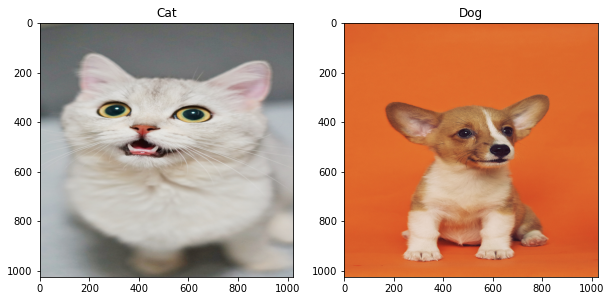

In [7]:
from urllib.request import urlopen

# plot cat and dog with title using PIL
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
cat = PIL.Image.open(urlopen(cat_p))
plt.imshow(cat.resize((1024, 1024)))
plt.title("Cat")
plt.subplot(1, 2, 2)
dog = PIL.Image.open(urlopen(dog_p))
plt.imshow(dog.resize((1024, 1024)))
plt.title("Dog")
plt.show();

## Convolution Layers <a id="2.3"></a>

The image and content are referenced with courtesy from [Tarun's notebook](https://www.kaggle.com/tarunpaparaju/plant-pathology-2020-eda-models](https://www.kaggle.com/tarunpaparaju/plant-pathology-2020-eda-models).

---

Convolution is a rather simple algorithm which involves a kernel (a 2D matrix) which moves over the entire image, calculating dot products with each window along the way. The GIF below demonstrates convolution in action.

<center><img src="https://storage.googleapis.com/reighns/reighns_ml_projects/docs/deep_learning/computer_vision/visualizing_convolutional_filters/conv_filter_1.gif" width="450px"></center>

The above process can be summarized with an equation, where *f* is the image and *h* is the kernel. The dimensions of *f* are *(m, n)* and the kernel is a square matrix with dimensions smaller than *f*:
$$\text{conv}(f, h) = \sum_{j}\sum_{k}h_{jk} \cdot f_{(m-j)(n-k)}$$

In the above equation, the kernel *h* is moving across the length and breadth of the image. The dot product of *h* with a sub-matrix or window of matrix *f* is taken at each step, hence the double summation (rows and columns). 

I have always remembered from the revered Andrew Ng about how he taught us about what convolutional layers do.

> In the beginning, the conv layers are of low level abstraction, detailing a image's features such as shapes and sizes. In particular, he described to us the horizontal and vertical conv filters. As the conv layers go later, it will pick up on many abstract features, which is not really easily distinguished by human eyes.

Below, we see an example of horizontal and vertical filters.

In [8]:
def conv_horizontal(image: np.ndarray) -> None:
    """Plot the horizontal convolution of the image.

    Args:
        image (torch.Tensor): [description]
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
    kernel = np.ones((3, 3), np.float32)
    kernel[1] = np.array([0, 0, 0], np.float32)
    kernel[2] = np.array([-1, -1, -1], np.float32)
    conv = cv2.filter2D(image, -1, kernel)
    ax[0].imshow(image)
    ax[0].set_title("Original Image", fontsize=24)
    ax[1].imshow(conv)
    ax[1].set_title("Convolved Image with horizontal edges", fontsize=24)
    plt.show()


def conv_vertical(image: np.ndarray) -> None:
    """Plot the vertical convolution of the image.

    Args:
        image (torch.Tensor): [description]
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
    kernel = np.ones((3, 3), np.float32)
    kernel[0] = np.array([1, 0, -1])
    kernel[1] = np.array([1, 0, -1])
    kernel[2] = np.array([1, 0, -1])
    conv = cv2.filter2D(image, -1, kernel)
    ax[0].imshow(image)
    ax[0].set_title("Original Image", fontsize=24)
    ax[1].imshow(conv)
    ax[1].set_title("Convolved Image with vertical edges", fontsize=24)
    plt.show()

Well, I can easily make out the horizontal and vertical edges from the dog image! Actually, not so obvious if you don't look closely! 

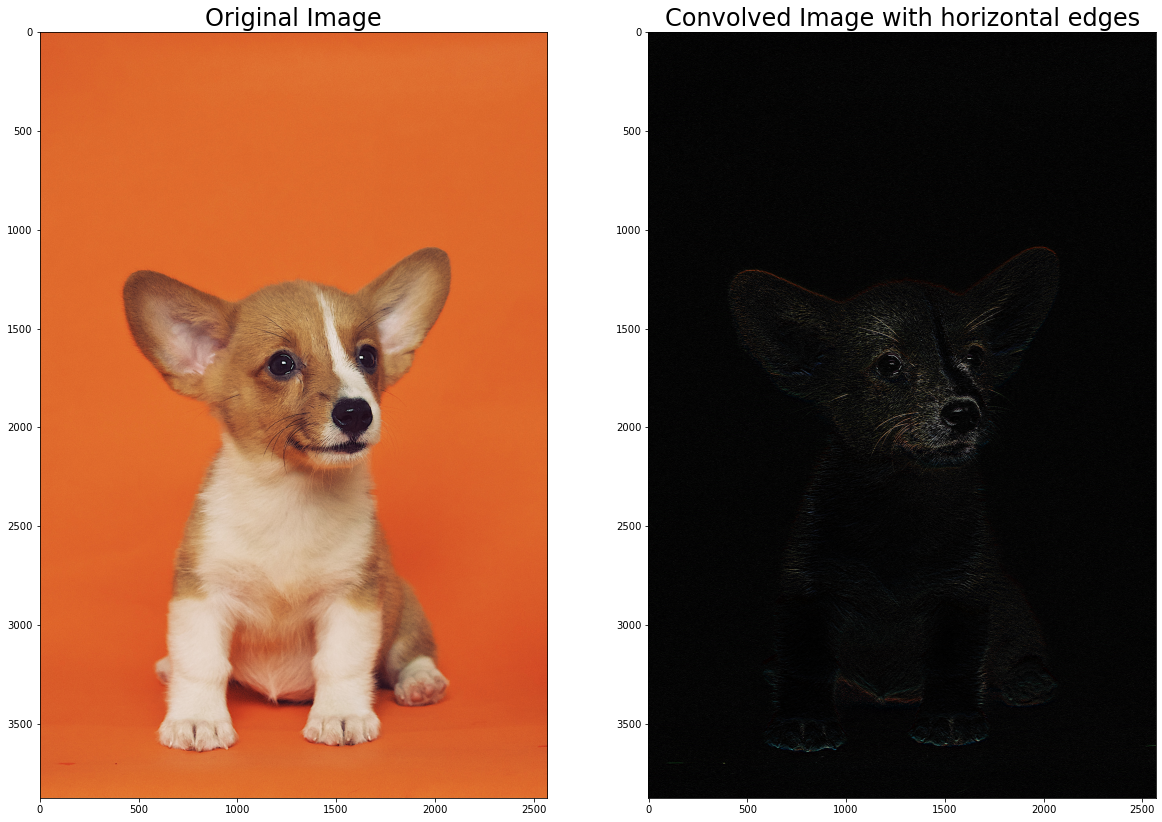

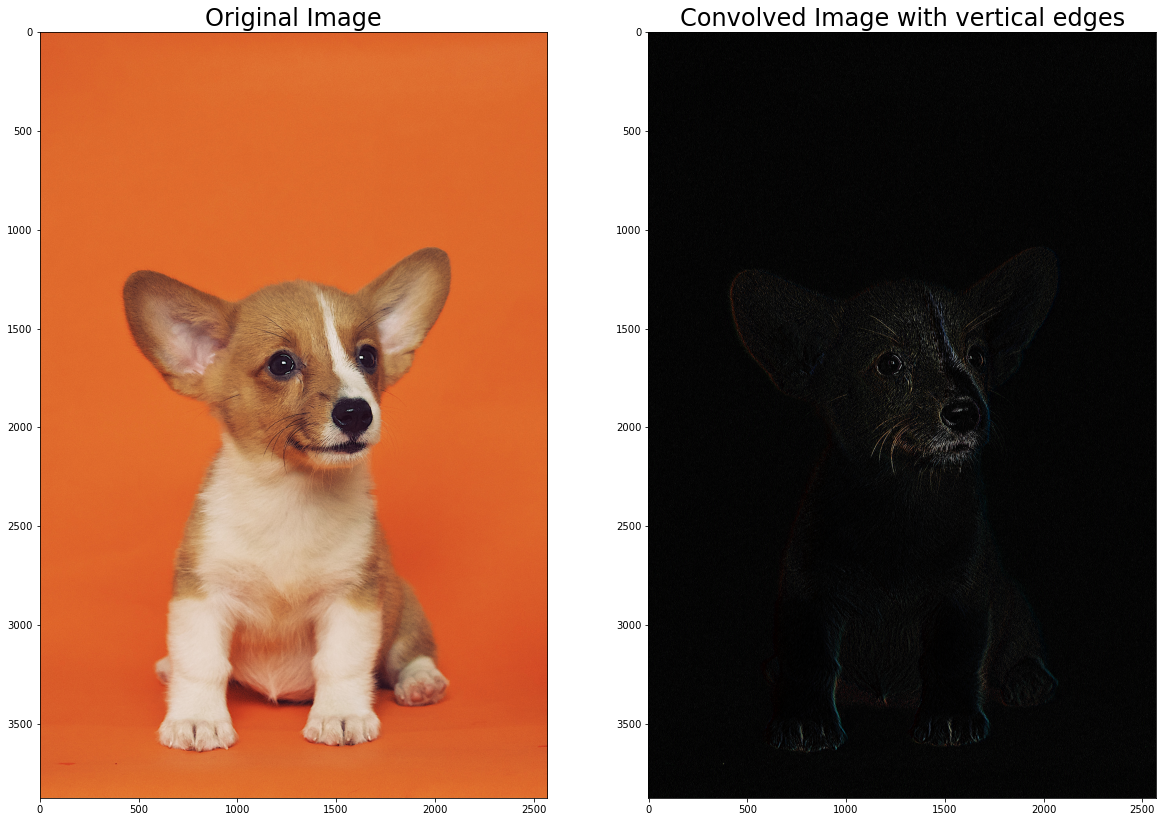

In [9]:
conv_horizontal(np.asarray(dog))
conv_vertical(np.asarray(dog))

The issue is, I want to visualize what our models' conv layers are seeing, like for example, the first conv layer usually has 64 filters, that is a whooping 64 different combinations of filters, each doing a slightly different thing. A mental model that I have for the first conv layer looks something like the following.

```python
conv_1_filters = ["vertical edge detector", "horizontal edge detector",
                  "slanted 45 degrees detector", "slanted 180 degrees detector",
                  ...]
```

### Feature Extractor using PyTorch's native Feature Extraction Module

In order to visualize properly, I made use of **PyTorch's** newest `feature_extraction` module to do so. Note that the new feature is still in development, but it does make my life easier and reduces overhead. I no longer need use `hooks` or what not to plot layer information!

We just need to import
```python
from torchvision.models.feature_extraction import (create_feature_extractor,
                                                   get_graph_node_names)
```

In [11]:
def get_conv_layers(model: torchvision.models) -> Dict[str, str]:
    """Create a function that give me the conv layers of PyTorch model.

    Args:
        model (Union[torchvision.models, timm.models]): A PyTorch model.

    Returns:
        conv_layers (Dict[str, str]): {"layer1.0.conv1": layer1.0.conv1, ...}
    """
    conv_layers = {}
    for name, layer in model.named_modules():
        if isinstance(layer, torch.nn.Conv2d):
            conv_layers[name] = name
    return conv_layers


def get_feature_maps(
    model_name: str, image: torch.Tensor, reduction: str = "mean",
    pretrained: bool = True
) -> Union[Dict[str, torch.Tensor], List[torch.Tensor], List[str]]:
    """Function to plot feature maps from PyTorch models.

    Args:
        model_name (str): Name of the model to use.
        image (torch.Tensor): image should be a tensor of shape (1, 3, H, W)
        reduction (str, optional): Defaults to "mean". One of ["mean", "max", "sum"]
        pretrained (bool): whether the model is pretrained or not

    Raises:
        ValueError: Must use Torchvision models.

    Returns:
        model_feature_maps (Dict[str, torch.Tensor]): {"conv_1": conv_1_feature_map, ...}
        processed_feature_maps (List[torch.Tensor]): [conv_1_feature_map, ...] processed using a reduction method.
        feature_map_names (List[str]): [conv_1, ...]

    Example:
        >>> from torchvision.models.vgg import vgg16
        >>> model = vgg16(pretrained=True)
        >>> image = torch.rand(1, 3, 224, 224)
        >>> feature_maps = get_feature_maps(model, image, reduction="mean")

    Reduction:
        If a feature map has 4 filters, in the shape of (4, H, W) = (4, 32, 32), then the reduction can be done as follows:
        >>> reduction = "mean": There are 4 filters in this feature map, you can imagine it as 4 32x32 images.
                                We sum up all 4 filters element-wise and get a single 32x32 image.
                                Then we take the mean of all 32x32 images by dividing by num of kernels to get a single 32x32 image, which is reduction="mean".
    """

    try:
        model = getattr(torchvision.models, model_name)(pretrained=pretrained)
    except AttributeError:
        raise ValueError(f"Model {model_name} not found.")

    train_nodes, eval_nodes = get_graph_node_names(model)
    logger.info(f"The train nodes of the model graph is:\n\n{train_nodes}")

    return_conv_nodes = get_conv_layers(model)
    feature_extractor = create_feature_extractor(model, return_nodes=return_conv_nodes)

    # `model_feature_maps` will be a dict of Tensors, each representing a feature map
    model_feature_maps = feature_extractor(image)

    processed_feature_maps = []
    feature_map_names = []

    for conv_name, conv_feature_map in model_feature_maps.items():

        conv_feature_map = conv_feature_map.squeeze(dim=0)
        num_filters = conv_feature_map.shape[0]

        if reduction == "mean":
            gray_scale = torch.sum(conv_feature_map, dim=0) / num_filters
        elif reduction == "max":
            gray_scale = torch.max(conv_feature_map, dim=0)
        elif reduction == "sum":
            gray_scale = torch.sum(conv_feature_map, dim=0)

        processed_feature_maps.append(gray_scale.data.cpu().numpy())
        feature_map_names.append(conv_name)

    return model_feature_maps, processed_feature_maps, feature_map_names

### Visualizing VGG16 and ResNet18

#### Step 1: Initialize the models.

As of now, I recommend using `torchvision`'s models. Ideally, I will want to use `timm` library for a more detailed list, but there are some bugs that is not easily integrated with the module.

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torchvision.models as models

vgg16_pretrained_true = models.vgg16(pretrained=True)
vgg16_pretrained_true = vgg16_pretrained_true.to(device)

resnet18_pretrained_true = models.resnet18(pretrained=True)
resnet18_pretrained_true = resnet18_pretrained_true.to(device)

In [13]:
# Get node names
train_nodes, eval_nodes = get_graph_node_names(vgg16_pretrained_true)
logger.info(f"Train nodes of VGG16:\n\n{train_nodes}")

train_nodes, eval_nodes = get_graph_node_names(resnet18_pretrained_true)
logger.info(f"Train nodes of ResNet18:\n\n{train_nodes}")

2021-12-29 19:06:08: Train nodes of VGG16:

['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'features.21', 'features.22', 'features.23', 'features.24', 'features.25', 'features.26', 'features.27', 'features.28', 'features.29', 'features.30', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']
2021-12-29 19:06:08: Train nodes of ResNet18:

['x', 'conv1', 'bn1', 'relu', 'maxpool', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.add', 'layer1.0.relu_1', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.1.add', 'layer1.1.relu_1', 'layer2.0.conv1', 'layer2.0.bn1',

**Good God!** When I saw the layer names from `vgg16`, I nearly fainted, I see no easy way to know which layer belongs to a Conv layer. I understand that `get_graph_node_names` will get all the nodes on the model's graph, but it is difficult to map the node names to a layer if it is named as such, seeing `resnet18`'s node names is much easier for one to identify which is conv layer or not.

```python
train_nodes, eval_nodes = get_graph_node_names(model)
logger.info(f"The train nodes of the model graph is:\n\n{train_nodes}")
```

Thus I wrote a small function `get_conv_layers` to get the conv layer names. It is not perfect, as downsample layers (1x1 conv layers) are tagged under `Conv2d` but we may not really need to use them to visualize our feature maps. One can tweak a bit if need be, but for now, I will get all layers that use the `Conv2d` blocks.

If the feature names in vgg16 are named with conv, then we can simply use a small loop below to find the conv layer names.

```python
conv_layers = []
for node in nodes:
    if "conv" in node:
        conv_layers.append(node)
```

I actually thought ResNet18 has 18 conv layers, but even minusing to 3 downsample layers, it's 17 conv layers, wonder why?

#### Step 2: Transform the Tensors

The PyTorch `feature_extraction` expects the image input to be of shape `[B,C,H,W]`. 

```python
# We use torchvision's transform to transform the cat image to channels first.
cat_tensor = transform(cat)

# Now feature_extractor expects batch_size x C x H x W, so we expand one dimension in the 0th dim
cat_tensor = cat_tensor.unsqueeze(dim=0).to(device)
```

In [14]:
# We use torchvision's transform to transform the cat image with resize and normalization.
# Conveniently, also making it channel first!
cat_tensor = transform(cat)
dog_tensor = transform(dog)
assert cat_tensor.shape[0] == dog_tensor.shape[0] == 3, "PyTorch expects Channel First!"

# Now feature_extractor expects batch_size x C x H x W, so we expand one dimension in the 0th dim
cat_tensor = cat_tensor.unsqueeze(dim=0).to(device)
dog_tensor = dog_tensor.unsqueeze(dim=0).to(device)

logger.info(f"\n\ncat_tensor's shape:\n{cat_tensor.shape}\n\ndog_tensor's shape:\n{dog_tensor.shape}")

2021-12-29 19:06:10: 

cat_tensor's shape:
torch.Size([1, 3, 224, 224])

dog_tensor's shape:
torch.Size([1, 3, 224, 224])


#### Step 3: Plotting the Feature Maps

We first walk through `get_feature_maps` and see what my function is doing.

```python
# Get node names
train_nodes, eval_nodes = get_graph_node_names(model)

# Since get node names do not indicate properly which is a conv layer or not,
# we use get_conv_layer instead to do the job, which returns a dict {"conv_layer_name": "conv_layer_name"}
return_conv_nodes = get_conv_layers(model)

# call create_feature_extractor on the model and its corresponding conv layer names.
feature_extractor = create_feature_extractor(model, return_nodes=return_conv_nodes)

# `model_feature_maps` will be a dict of Tensors, each representing a feature map
# {"conv_layer_1": output filter map,...}
model_feature_maps = feature_extractor(image)

# we need to further process the feature maps
processed_feature_maps, feature_map_names = [], []


for conv_name, conv_feature_map in model_feature_maps.items():
    # Squeeze the dimension from [1, 64, 32, 32] to [64, 32, 32]
    # This means we have 64 filters of 32x32 "images" or kernels
    conv_feature_map = conv_feature_map.squeeze(dim=0)
    # get number of feature/kernels in this layer
    num_filters = conv_feature_map.shape[0]
    

    # If a feature map has 4 filters, in the shape of (4, H, W) = (4, 32, 32), then the reduction mean can be done as follows: There are 4 filters in this feature map, you can imagine it as 4 32x32 images.
    # Step 1: We sum up all 4 filters element-wise and get a single 32x32 image.
    # Step 2: Then we take the mean of all 32x32 images to get a single 32x32 image, which is reduction="mean".
    if reduction == "mean":
        gray_scale = torch.sum(conv_feature_map, dim=0) / num_filters
    elif reduction == "max":
        gray_scale = torch.max(conv_feature_map, dim=0)
    elif reduction == "sum":
        gray_scale = torch.sum(conv_feature_map, dim=0)

    processed_feature_maps.append(gray_scale.data.cpu().numpy())
    feature_map_names.append(conv_name)
```

In [15]:
_, vgg16_processed_feature_maps, vgg16_feature_map_names = get_feature_maps(
    model_name="vgg16", image=cat_tensor, reduction="mean", pretrained=True
)
_, resnet18_processed_feature_maps, resnet18_feature_map_names = get_feature_maps(
    model_name="resnet18", image=cat_tensor, reduction="mean", pretrained=True
)

2021-12-29 19:06:12: The train nodes of the model graph is:

['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'features.21', 'features.22', 'features.23', 'features.24', 'features.25', 'features.26', 'features.27', 'features.28', 'features.29', 'features.30', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']
2021-12-29 19:06:12: The train nodes of the model graph is:

['x', 'conv1', 'bn1', 'relu', 'maxpool', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.add', 'layer1.0.relu_1', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.1.add', 'layer1.1.relu_1', 'l

Then we create a simple `plot_feature_maps` that take in the `processed_feature_maps` and `feature_map_names` to plot them.

In [16]:
def plot_feature_maps(
    processed_feature_maps: List[torch.Tensor], feature_map_names: List[str], nrows: int,
    title: str = None
) -> None:
    """Plot the feature maps.

    Args:
        processed_feature_maps (List[torch.Tensor]): [description]
        feature_map_names (List[str]): [description]
        nrows (int): [description]
    """
    fig = plt.figure(figsize=(30, 50))
    ncols = len(processed_feature_maps) // nrows + 1
    for i in range(len(processed_feature_maps)):
        a = fig.add_subplot(nrows, ncols, i + 1)
        imgplot = plt.imshow(processed_feature_maps[i])
        a.axis("off")
        a.set_title(feature_map_names[i].split("(")[0], fontsize=30)

    fig.suptitle(title, fontsize=50)

    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.savefig(title, bbox_inches='tight')
    plt.show();

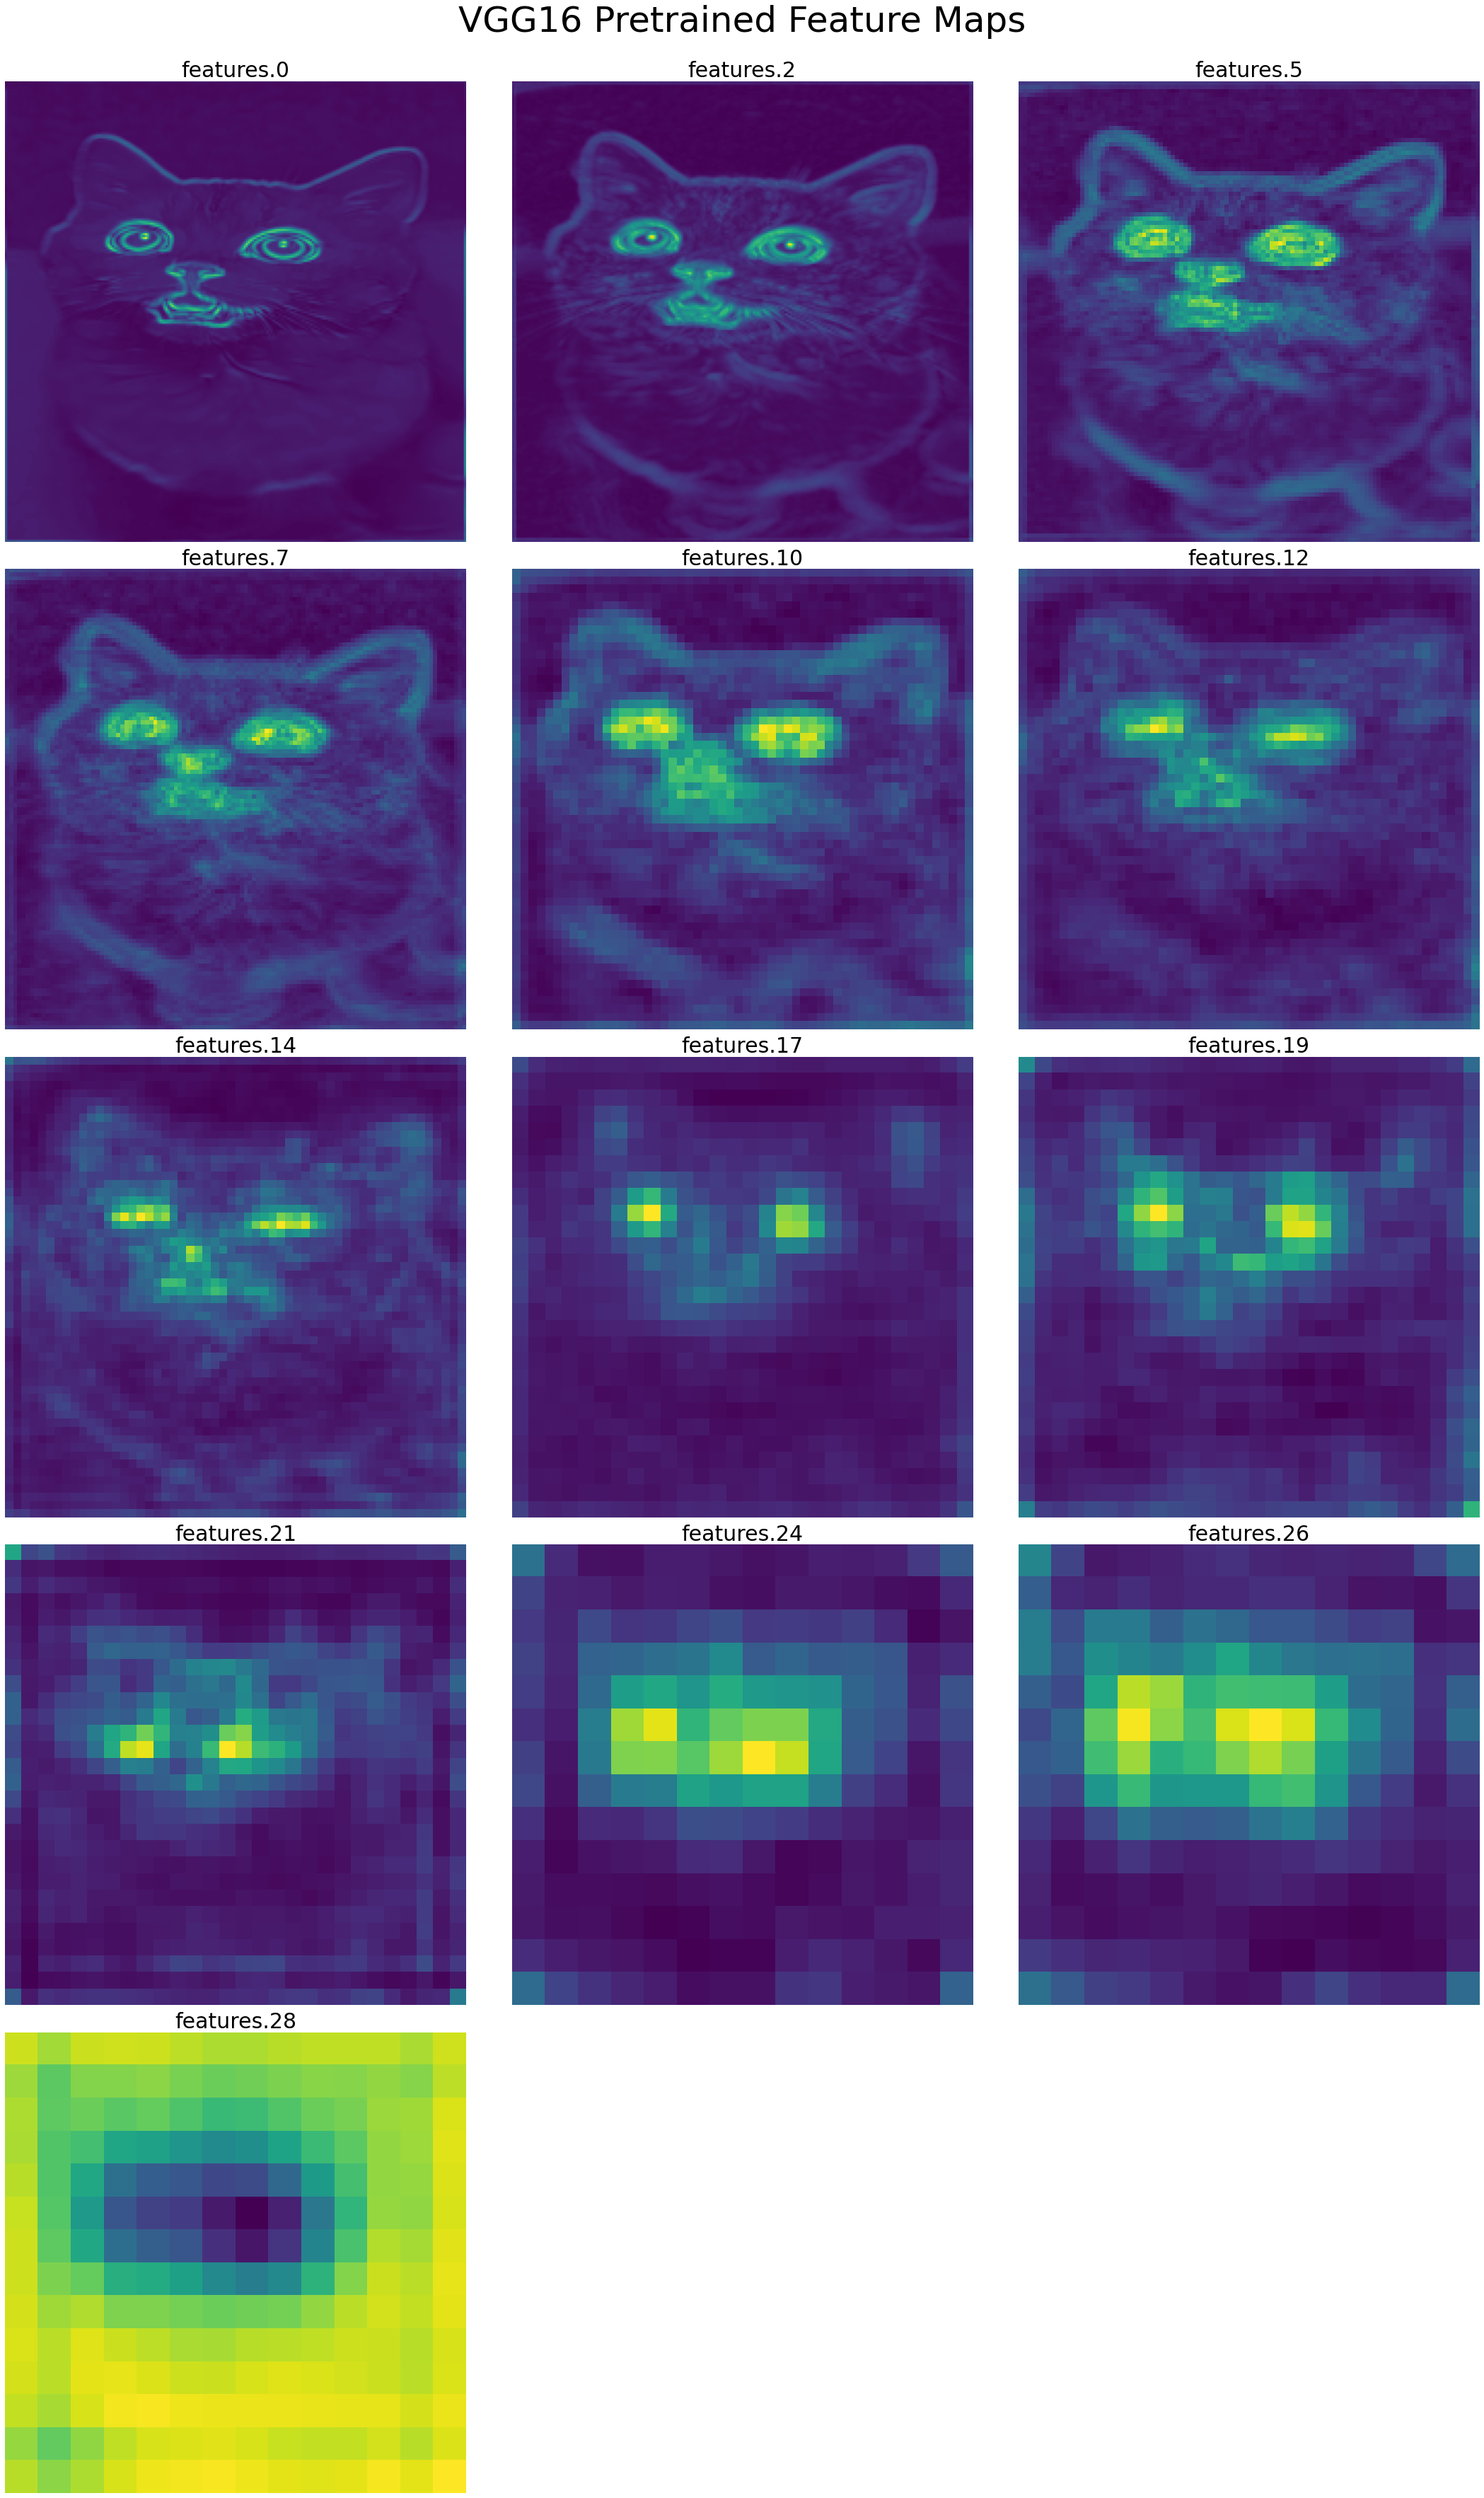

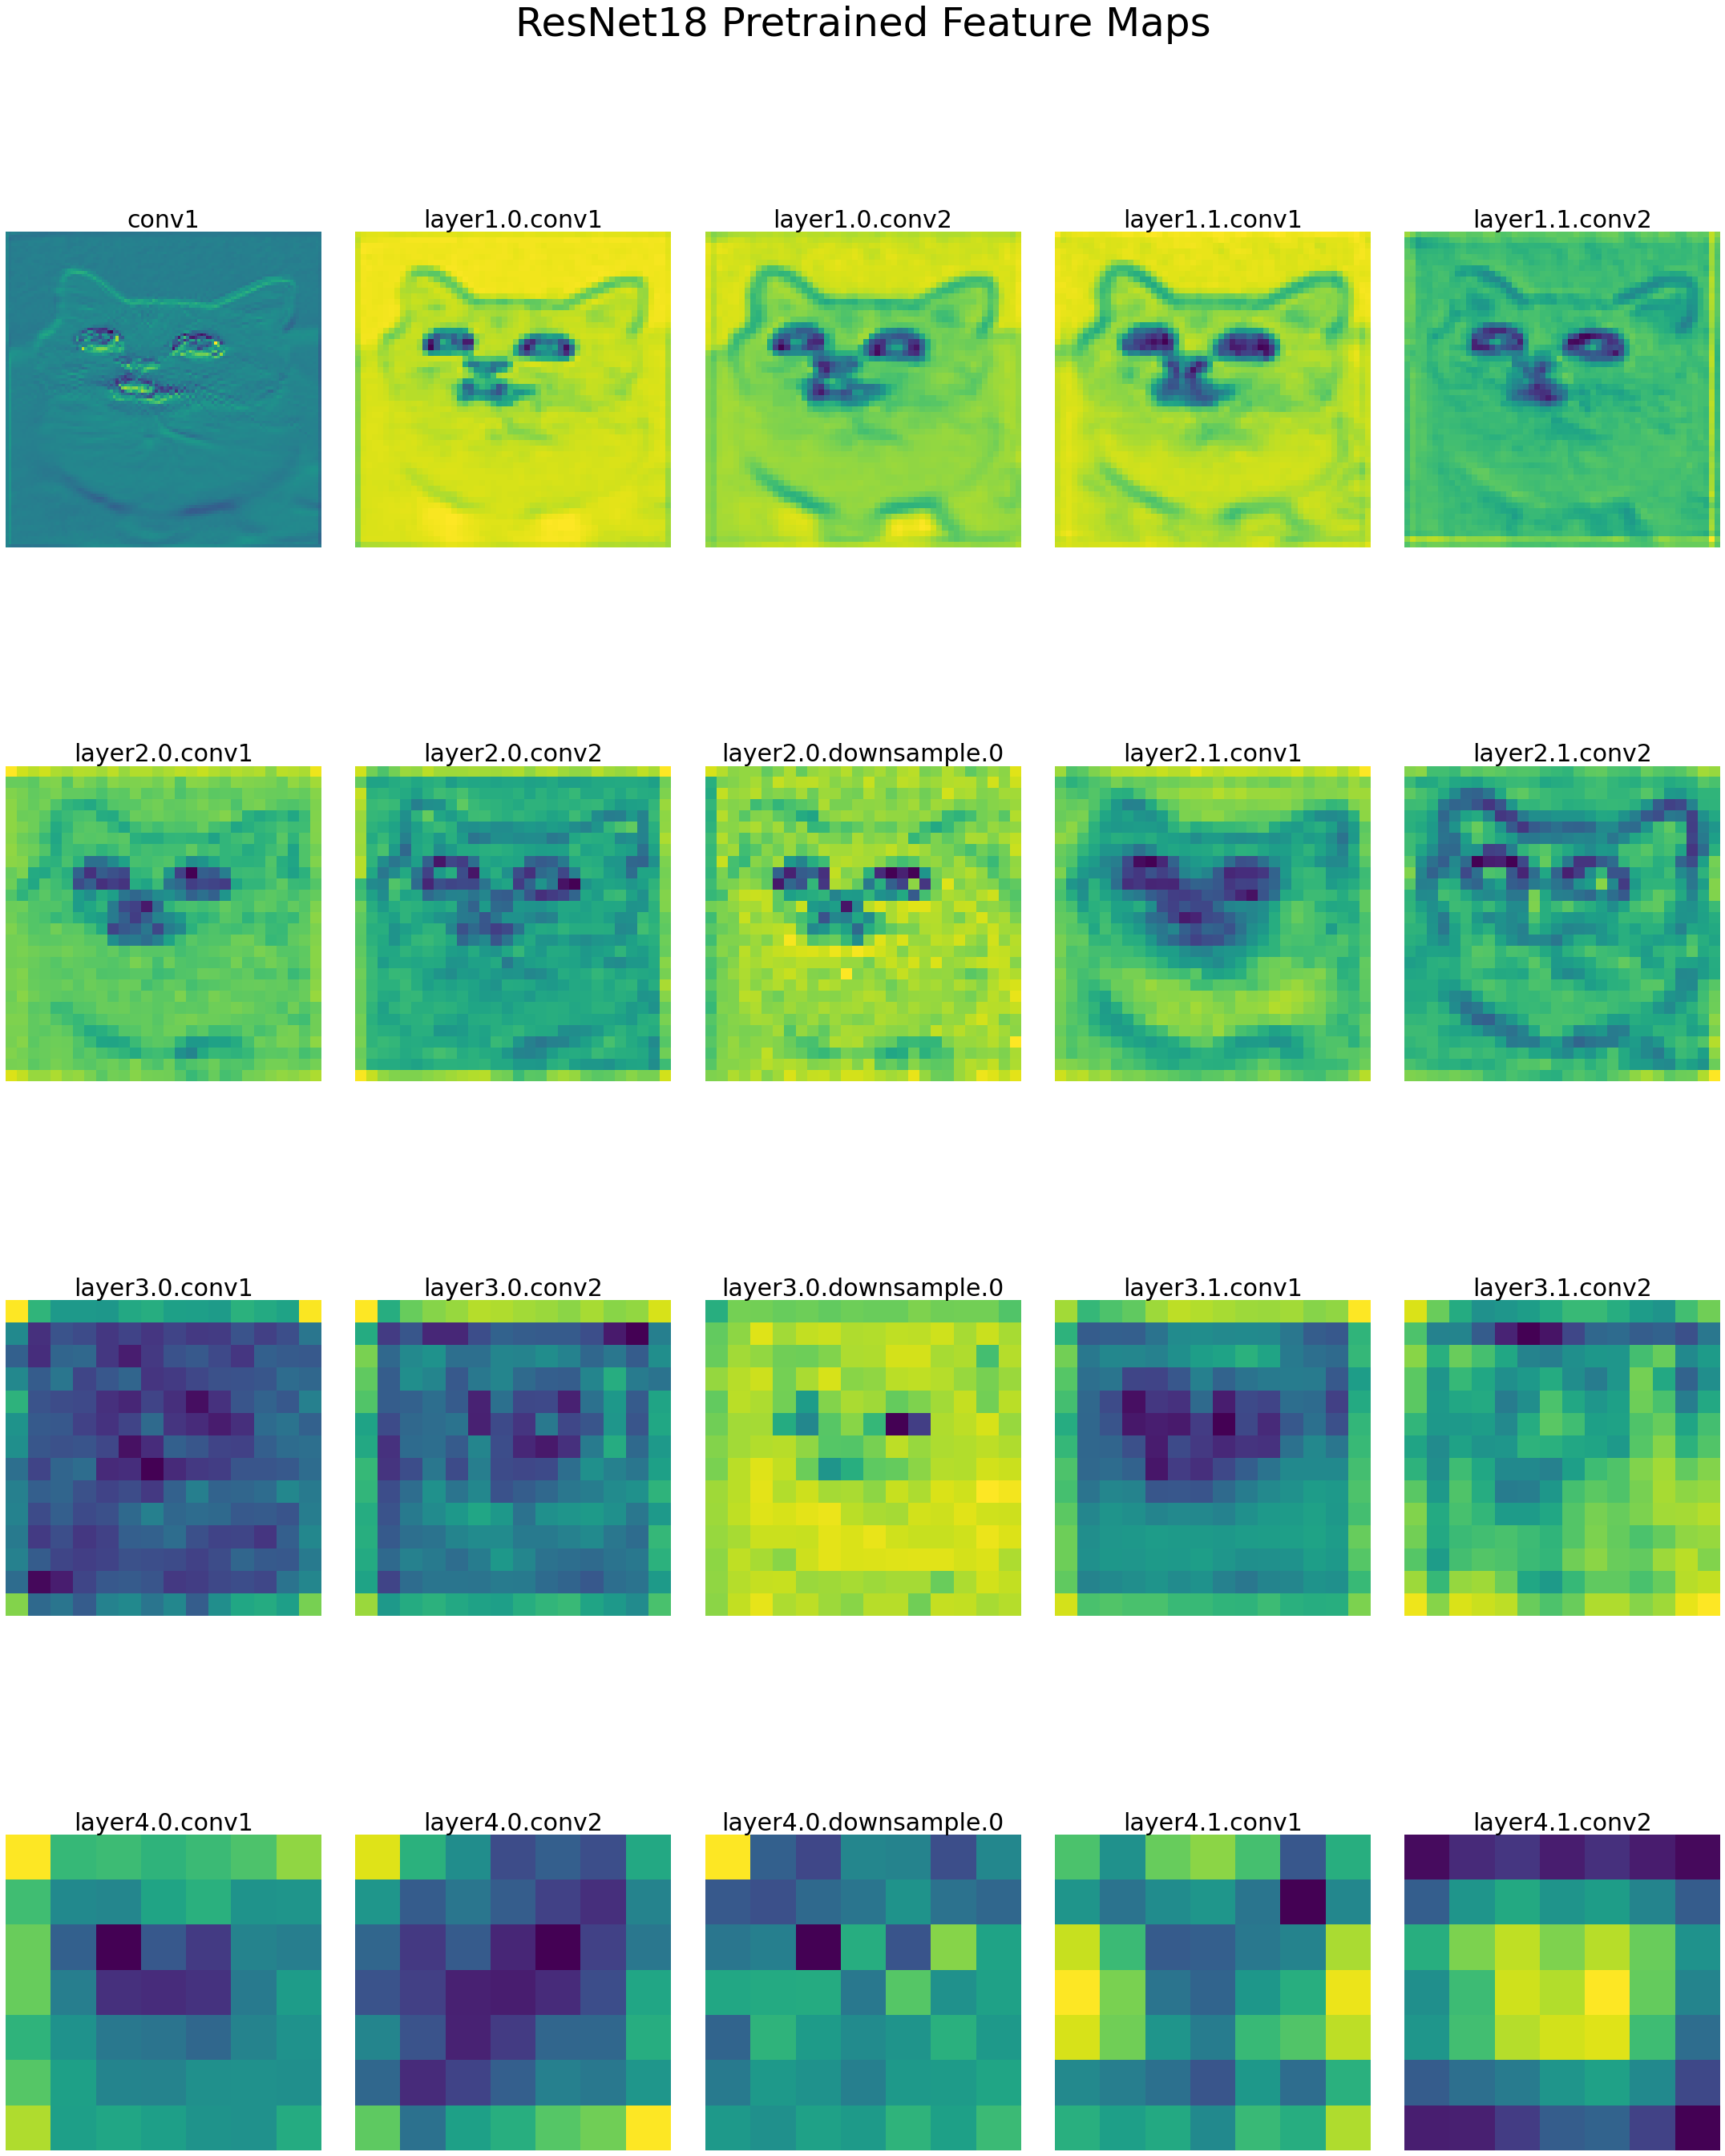

In [17]:
plot_feature_maps(
    vgg16_processed_feature_maps,
    vgg16_feature_map_names,
    nrows=5,
    title="VGG16 Pretrained Feature Maps",
)

plot_feature_maps(
    resnet18_processed_feature_maps,
    resnet18_feature_map_names,
    nrows=5,
    title="ResNet18 Pretrained Feature Maps",
)

## Comparison with Randomly Initialized Weights

We know that if the model is not pretrained, it will initialize with random weights using weight initialization methods such as Kaimin or Xavier. I expect the edges to be not so "smooth" as the ones that are pretrained! This is logical, as the filters in the conv layers are mostly random, and we have not trained any epochs yet, so let's see what it gives us.

In [18]:
_, vgg16_processed_feature_maps, vgg16_feature_map_names = get_feature_maps(
    model_name="vgg16", image=cat_tensor, reduction="mean", pretrained=False
)
_, resnet18_processed_feature_maps, resnet18_feature_map_names = get_feature_maps(
    model_name="resnet18", image=cat_tensor, reduction="mean", pretrained=False
)

2021-12-29 19:06:21: The train nodes of the model graph is:

['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'features.21', 'features.22', 'features.23', 'features.24', 'features.25', 'features.26', 'features.27', 'features.28', 'features.29', 'features.30', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']
2021-12-29 19:06:21: The train nodes of the model graph is:

['x', 'conv1', 'bn1', 'relu', 'maxpool', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.add', 'layer1.0.relu_1', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.1.add', 'layer1.1.relu_1', 'l

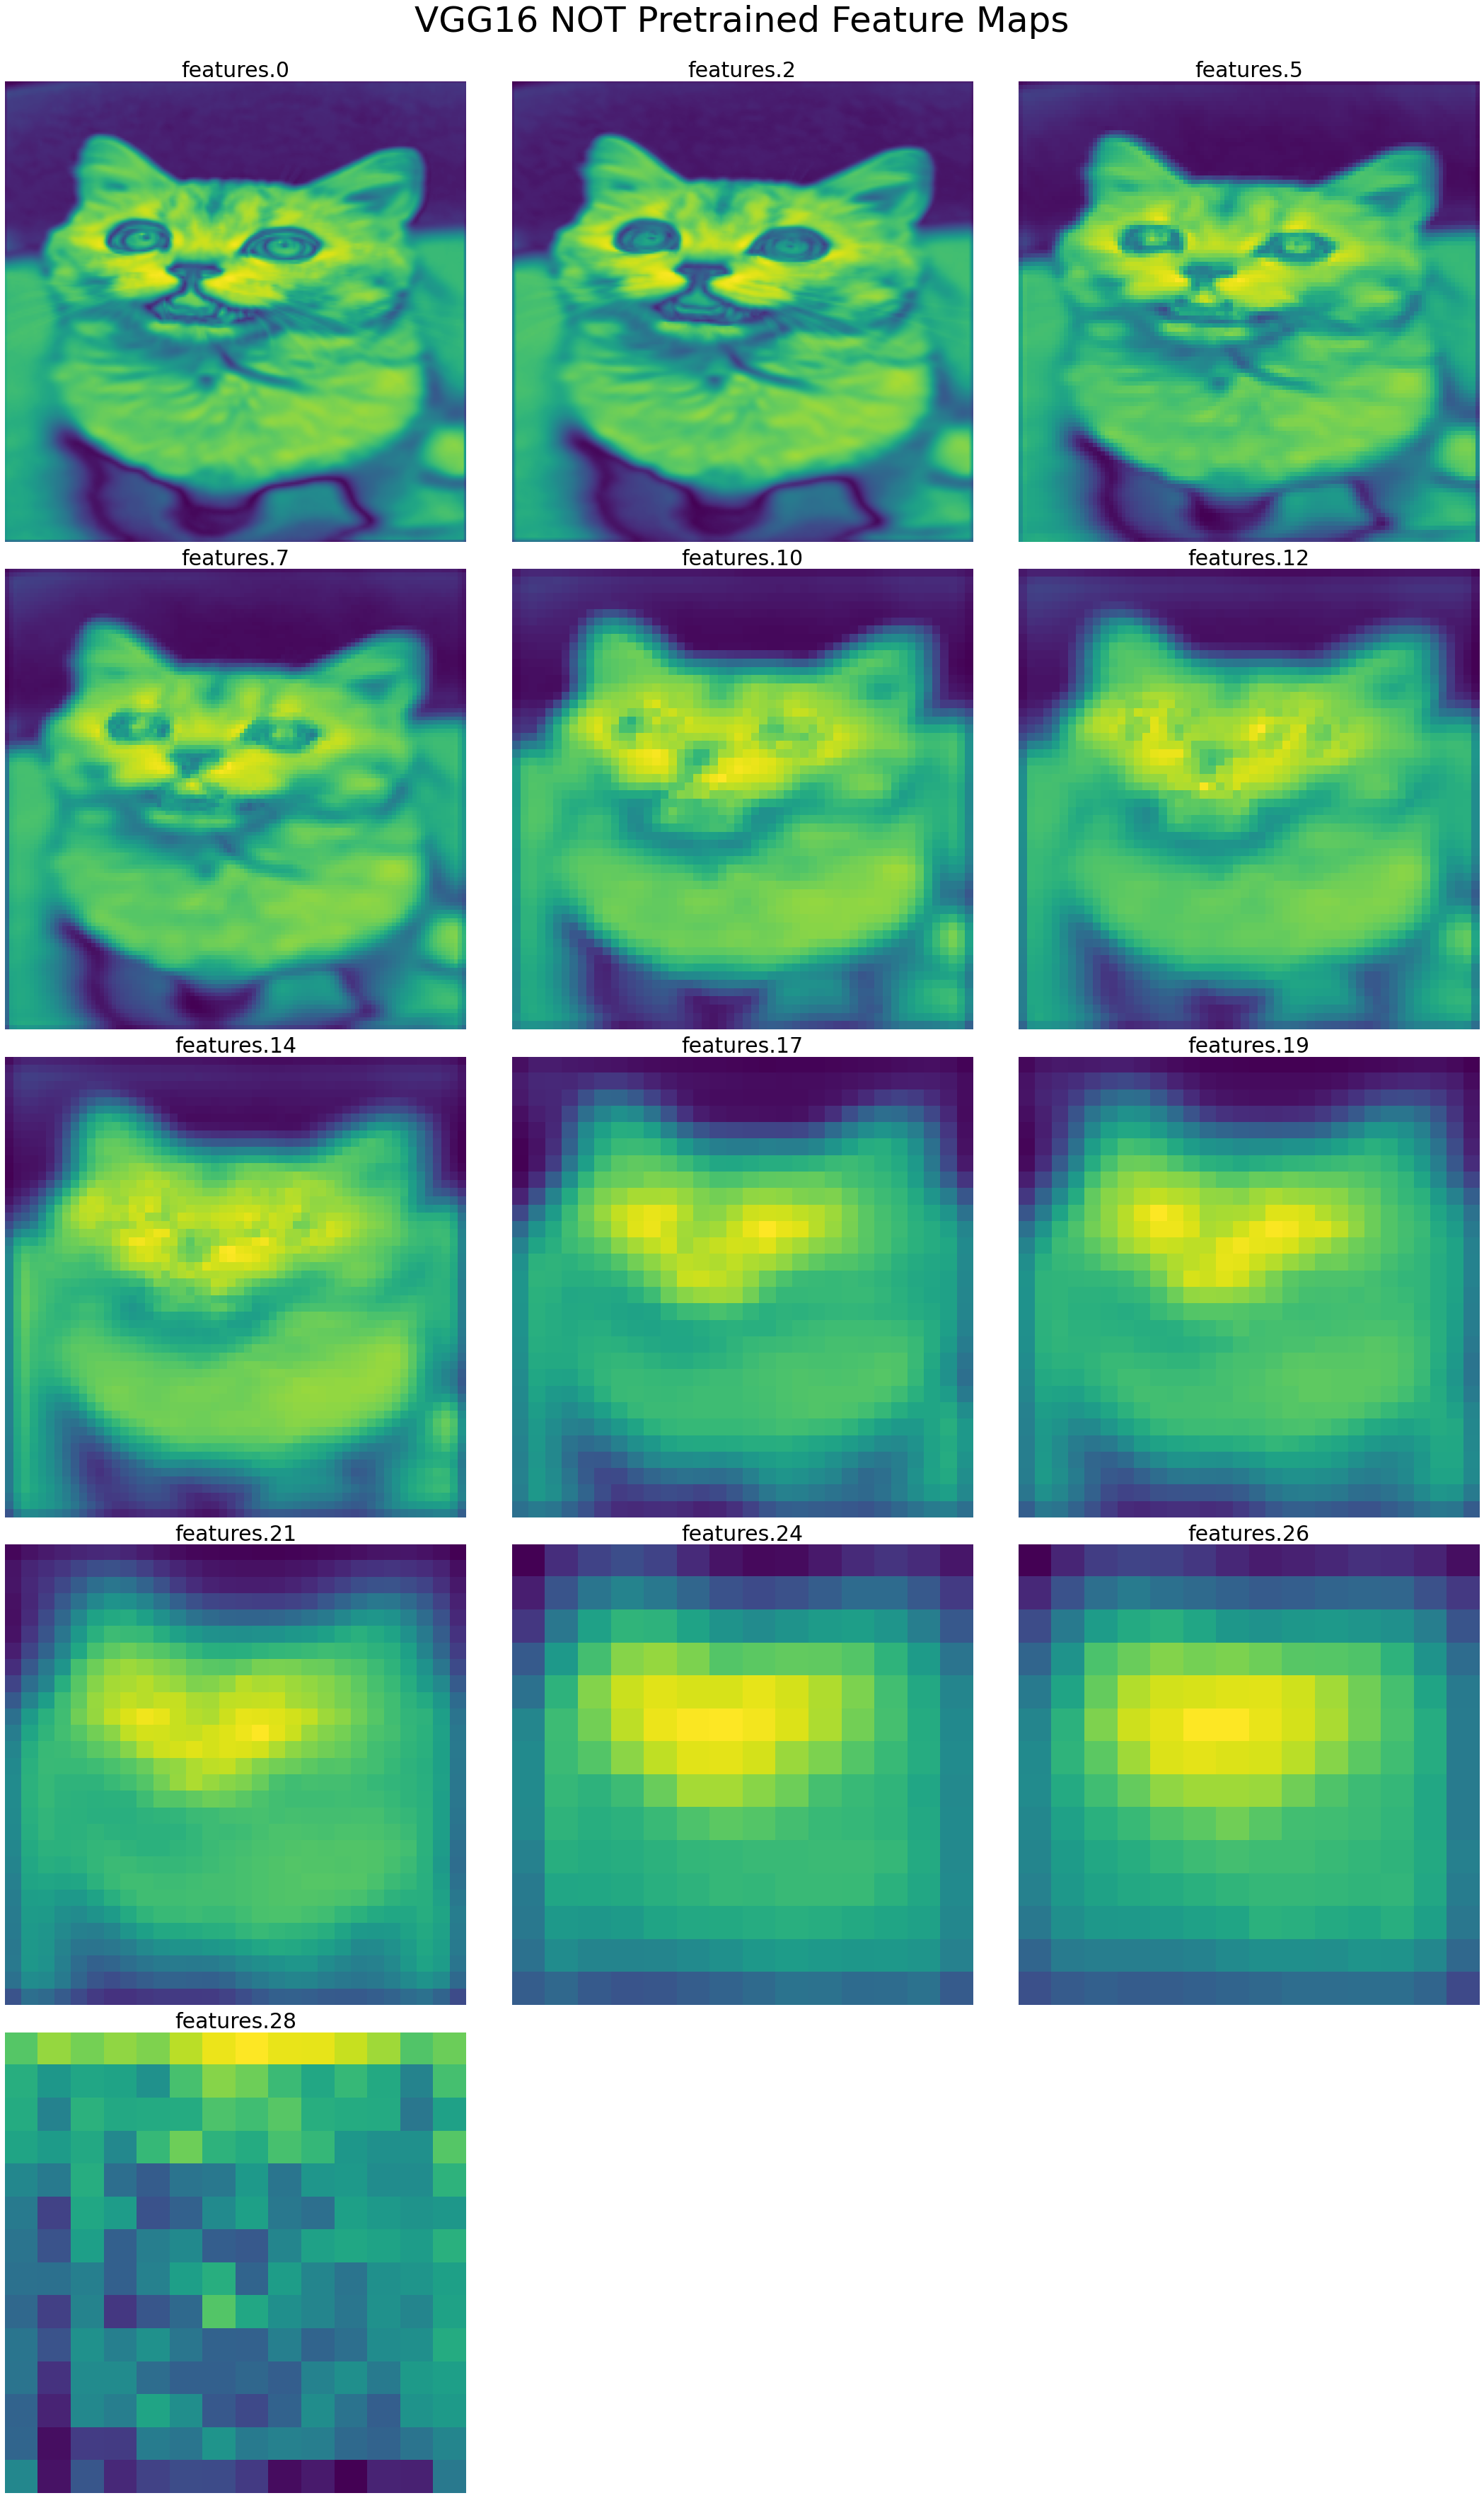

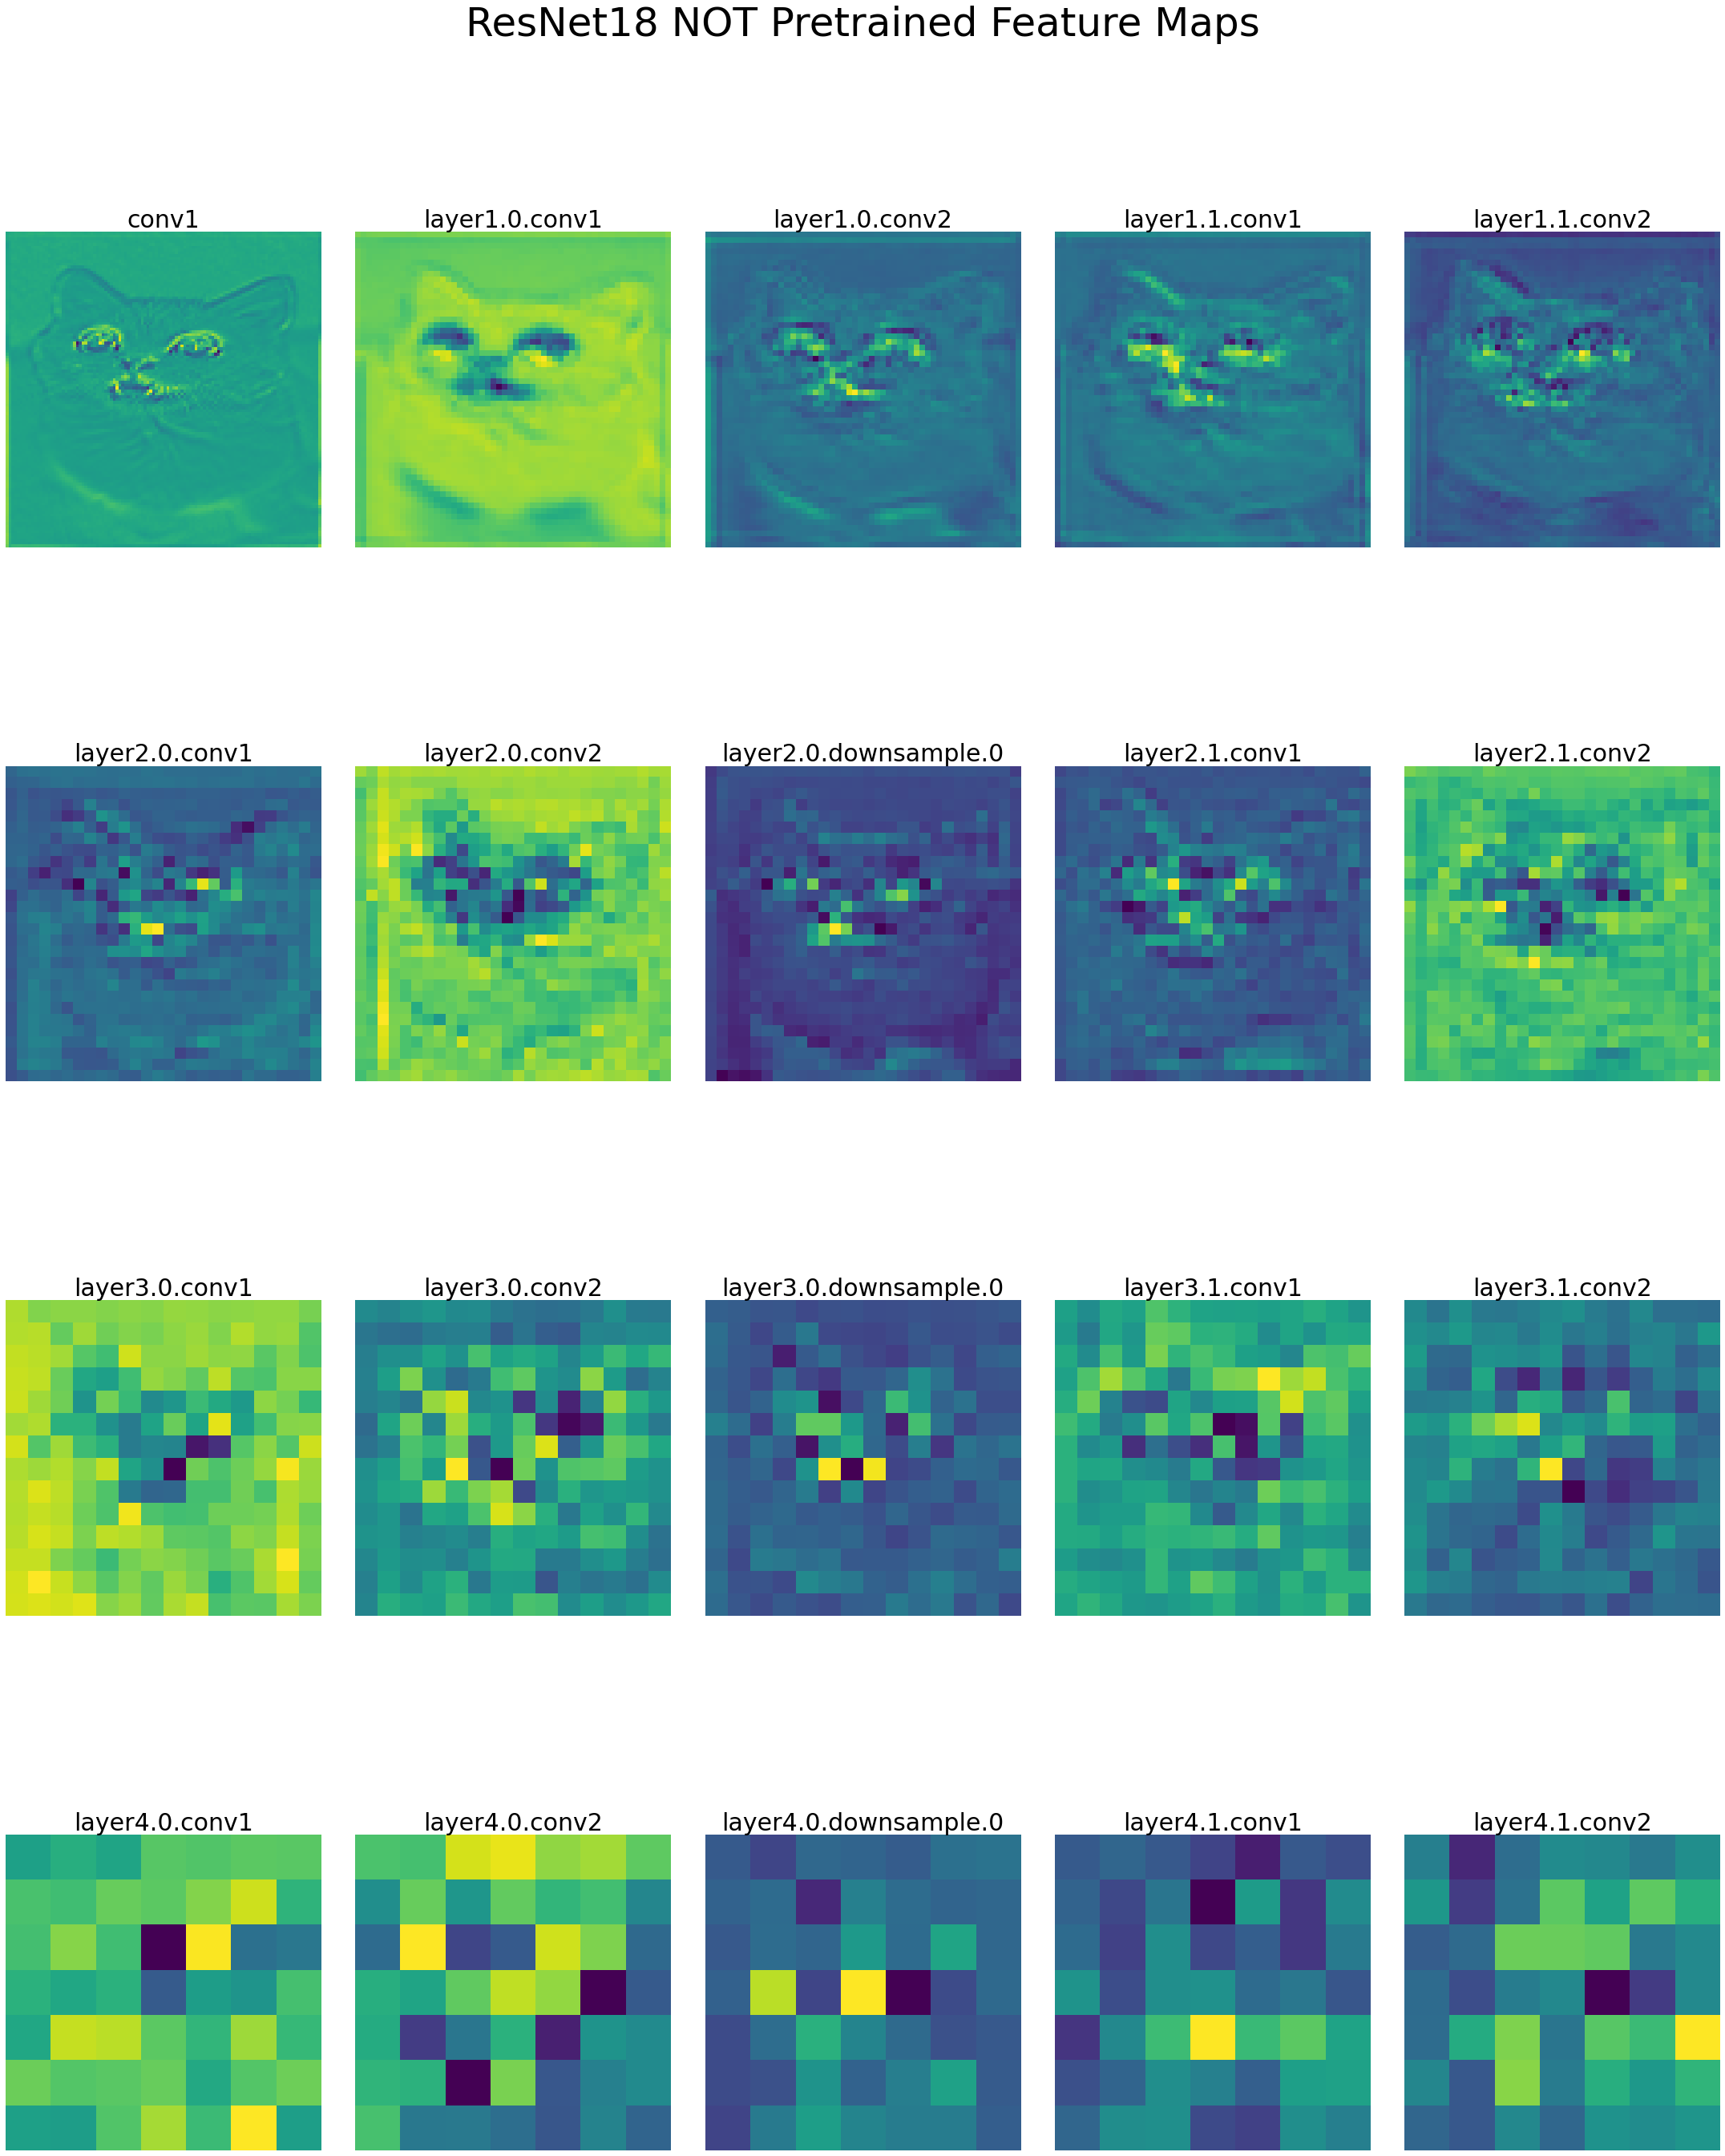

In [19]:
plot_feature_maps(
    vgg16_processed_feature_maps,
    vgg16_feature_map_names,
    nrows=5,
    title="VGG16 NOT Pretrained Feature Maps",
)
plot_feature_maps(
    resnet18_processed_feature_maps,
    resnet18_feature_map_names,
    nrows=5,
    title="ResNet18 NOT Pretrained Feature Maps",
)

References:

- [https://pytorch.org/vision/stable/feature_extraction.html](https://pytorch.org/vision/stable/feature_extraction.html)
- [https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch](https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573)
- [https://pytorch.org/blog/FX-feature-extraction-torchvision/](https://pytorch.org/blog/FX-feature-extraction-torchvision/)
- [https://www.kaggle.com/tarunpaparaju/plant-pathology-2020-eda-models](https://www.kaggle.com/tarunpaparaju/plant-pathology-2020-eda-models)